In [1]:
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD

import os
import numpy as np
from tensorflow.keras import regularizers
from poseidon.signal.lofar import tpsw, lofar
from poseidon.io.offline import load_raw_data
from poseidon.signal.utils import resample

def build_net(input_shape, output_shape, n_neurons, n_activations=["tanh"]):
    model = Sequential()
    
    model.add(Dense(n_neurons[0], 
#                     kernel_regularizer=regularizers.l2(0.01),
                    activation=n_activations[0], input_shape=input_shape))
    for neurons, activation in zip(n_neurons[1:], n_activations[1:]):
        if neurons == 0:
            continue
        model.add(Dense(neurons, activation=activation))#, kernel_regularizer=regularizers.l2(0.01)))
#         model.add(Dropout(0.5))
        
    model.add(Dense(output_shape, activation='softmax'))
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy', 'acc'])
    
    return model

In [143]:
import joblib
base_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
database = '4classes'
proc_data_path = os.path.join(base_dir, 'data', 'processed')

# datafile = '4_classes_clean_1024_7350.jbl'
# datafile = '4_classes_clean_1024_22050.jbl'
# datafile = '4_classes_clean_2048_7350.jbl'
# datafile = '24_classes_clean_2048_22050.jbl'
# datafile = '24_classes_clean_ne_2048_22050.jbl'
models_path = os.path.join(base_dir, 'models', 'topology_selection', datafile[:-4])

data, trgt = joblib.load(os.path.join(proc_data_path, datafile))

In [144]:
trgt[trgt > 2] = trgt[trgt > 2] - 1

In [145]:
np.unique(trgt)

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23.])

In [146]:
def getGradientWeights(y_train, mode='standard'):
        if y_train.ndim > 1:
            y_train = y_train.argmax(axis=1)

        cls_indices, event_count = np.unique(np.array(y_train), return_counts=True)
        min_class = min(event_count)

        return {cls_index: float(min_class) / cls_count
                for cls_index, cls_count in zip(cls_indices, event_count)}


In [147]:
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.preprocessing import StandardScaler
from itertools import product
import pandas as pd
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical

n_splits = 10

n_classes = np.unique(trgt).shape[0]
neurons_map = list(range(2,10+1,2))

combinations = list(range(2, 32, 2))


for layer1 in combinations:
    
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    cvo = skf.split(data, trgt)
    for i, (train, test) in enumerate(cvo):
        K.clear_session()
        np.random.shuffle(train)
        model_path = os.path.join(models_path, '%i' % (layer1), '%i_fold' % i)
        print('%i' % (layer1), end = '\t')
        print('%i_fold' % i)
        if os.path.exists(model_path):
            if os.path.exists(os.path.join(model_path, 'predictions.csv')):
                print('Already trained')
                continue
        else:
            os.makedirs(model_path)
        
        scaler = StandardScaler()
        
        X_train, X_test = data[train], data[test]
        y_train, y_test = trgt[train], trgt[test]
        
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        cls_weights = getGradientWeights(y_train - 1)
        y_train = to_categorical(y_train - 1, num_classes=n_classes)
        
        mc = ModelCheckpoint(save_best_only=True, 
                            filepath=os.path.join(model_path, 'weights'),
                            save_weights_only=True)
        for ik in range(10):
            model = build_net(input_shape=data[0].shape, output_shape=n_classes,
                          n_neurons=[layer1],
                          n_activations=['tanh']
                          )
            
            mc2 = ModelCheckpoint(save_best_only=True, 
                            filepath=os.path.join(model_path, 'weights_%i' % ik),
                            save_weights_only=True)
            es = EarlyStopping(patience=50)
        
            history = model.fit(X_train, y_train,
                                epochs=500, batch_size=128, class_weight=cls_weights,
                                callbacks=[mc, es, mc2], verbose=0, shuffle=True, validation_split=0.2)
            pd.DataFrame(history.history).to_csv(os.path.join(model_path, 'history_%i.csv' % ik))
        
        model.load_weights(os.path.join(model_path, 'weights'))
        y_pred = model.predict(X_test)
        pd.DataFrame(y_pred).to_csv(os.path.join(model_path, 'predictions.csv'))
    
        
    

2	0_fold
Already trained
2	1_fold
Already trained
2	2_fold
Already trained
2	3_fold
Already trained
2	4_fold
Already trained
2	5_fold
Already trained
2	6_fold
Already trained
2	7_fold
Already trained
2	8_fold
Already trained
2	9_fold
Already trained
4	0_fold
Already trained
4	1_fold
Already trained
4	2_fold
Already trained
4	3_fold
Already trained
4	4_fold
Already trained
4	5_fold
Already trained
4	6_fold
Already trained
4	7_fold
Already trained
4	8_fold
Already trained
4	9_fold
Already trained
6	0_fold
Already trained
6	1_fold
Already trained
6	2_fold
Already trained
6	3_fold
Already trained
6	4_fold
Already trained
6	5_fold
Already trained
6	6_fold
Already trained
6	7_fold
Already trained
6	8_fold
Already trained
6	9_fold
Already trained
8	0_fold
Already trained
8	1_fold
Already trained
8	2_fold
Already trained
8	3_fold
Already trained
8	4_fold
Already trained
8	5_fold
Already trained
8	6_fold
Already trained
8	7_fold
Already trained
8	8_fold
Already trained
8	9_fold
Already trained


In [170]:
import scipy
from sklearn.metrics import recall_score, precision_score, f1_score
def sp_index(recall):
    return np.sqrt(recall.mean()*np.power(np.prod(recall), 1/recall.shape[0]))

recall_list = ['Recall %i' % i for i in range(1,n_classes+1)]

results = dict()
columns = ['Layer1', 'Fold'] + recall_list + ['H-Recall', 'H-Precision', 'SP', 'F1 (macro)']
for j, layer1 in enumerate(combinations):
    
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    cvo = skf.split(data, trgt)
    for i, (train, test) in enumerate(cvo):
        model_path = os.path.join(models_path, '%i' % (layer1), '%i_fold' % i)
#         print('%i_%i_%i' % (layer1, layer2, layer3), end = '\t')
#         print('%i_fold' % i)
        
        predictions = pd.read_csv(os.path.join(model_path, 'predictions.csv'), index_col=0).values
        
        y_test = trgt[test]
        
        y_pred = predictions.argmax(axis=1)
        recall = recall_score(y_test - 1, y_pred, average=None)
        f1 = f1_score(y_test -1, y_pred, average='macro')
        precision = precision_score(y_test - 1, y_pred, average=None)
        sp = sp_index(recall)
        
#         sp = sp_index(recall)
        hrec = scipy.stats.hmean(recall + 1e-6)
        hprec = scipy.stats.hmean(precision + 1e-6)
        
#         print(recall.shape)
        results[(j, i)] = np.concatenate([[layer1, i], recall, [hrec, hprec, sp, f1]])
    
results = pd.DataFrame.from_dict(results, orient='index', columns=columns)

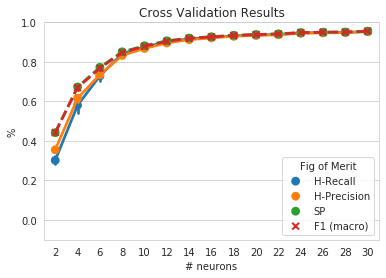

In [70]:
import seaborn as sns
import matplotlib.pyplot as plt
plotpath = os.path.join('.', 'plots', datafile[:-4])
if not os.path.exists(plotpath):
    os.makedirs(plotpath)

sns.set_style('whitegrid')

measures = results[['Layer1', 'H-Recall', 'H-Precision', 'SP', 'F1 (macro)']]
measures = measures.melt(id_vars='Layer1', var_name='Fig of Merit', value_name='%')
measures = measures.rename({'Layer1': '# neurons'}, axis=1)
measures['# neurons'] = measures['# neurons'].astype('int')
ax = sns.pointplot(data=measures, x='# neurons', y = '%', 
                   linestyles=['-', '-', '--', '--'],
                   markers=['o', 'o', 'o', 'x'],
                   hue='Fig of Merit')

ax.set_ylim(-0.1, 1)
ax.set_title("Cross Validation Results")
plt.savefig(os.path.join(plotpath, 'cross_val_results.png'), dpi=200)

In [71]:
(results[['Layer1', 'H-Recall', 'H-Precision', 'SP', 'F1 (macro)']]
     .rename({'Layer1' : '# neurons'}, axis=1)
     .groupby(['# neurons']).std()).tail()

,H-Recall,H-Precision,SP,F1 (macro)
# neurons,,,,
22.0,0.003589,0.003271,0.003383,0.003045
24.0,0.004425,0.004681,0.004159,0.004163
26.0,0.004621,0.003985,0.004281,0.003775
28.0,0.005256,0.005830,0.004844,0.005026
30.0,0.003979,0.003577,0.003586,0.003323


In [13]:
sns.set_style('whitegrid')
log_loss=True
for neurons in range(2,32,2):
    fig, axes = plt.subplots(nrows=10, ncols=2, figsize=(10, 50))
    plt.subplots_adjust(hspace=.3)
    for i in range(10):
        for sort in range(10):
            model_path = os.path.join(models_path, '%i' % neurons, '%i_fold' % i)
    #         print('%i_%i_%i' % (layer1, layer2, layer3), end = '\t')
    #         print('%i_fold' % i)

            history = pd.read_csv(os.path.join(model_path, 'history_%i.csv' % sort), index_col=0)
            training = history[['loss', 'val_loss']]

            val_loss = training['val_loss']
            train_loss = training['loss']
            n = 1
            if log_loss== True:
                val_loss = np.convolve(np.log10(val_loss), np.ones(n)/n, mode='same')
                train_loss = np.convolve(np.log10(train_loss), np.ones(n)/2, mode='same')
                logname_mod = 'log'
            else:
                val_loss = np.convolve(val_loss, np.ones(n)/n, mode='same')
                train_loss = np.convolve(train_loss, np.ones(n)/2, mode='same')
                logname_mod = 'nolog'
                
            if sort == 9:
                axes[i, 0].plot(range(len(training['loss'])), train_loss, color='b', label='loss')
                axes[i, 1].plot(range(len(training['val_loss'])), val_loss, color='r', label='val_loss')
                axes[i, 0].set_xlabel('Epoch', fontsize=15)
                axes[i, 0].set_ylabel('$log_{10}(loss)$', fontsize=15)
                axes[i, 0].set_title('Fold %i Train Loss' % i, fontsize=18)

                axes[i, 0].set_xlabel('Epoch', fontsize=15)
                axes[i, 1].set_ylabel('$log_{10}(val_loss)$', fontsize=15)
                axes[i, 1].set_title('Fold %i Val Loss' % i, fontsize=18)
            else:
                axes[i, 0].plot(range(len(training['loss'])), train_loss, color='b')
                axes[i, 1].plot(range(len(training['val_loss'])), val_loss, color='r')
    trainplot_path = os.path.join(plotpath, logname_mod)
    if not os.path.exists(trainplot_path):
        os.makedirs(trainplot_path)
    plt.savefig(os.path.join(trainplot_path, 'train_plot_neurons_%i.png' % neurons), bbox_inches='tight')
    plt.close()



In [171]:
in_res = (results.drop(['H-Recall', 'H-Precision', 'SP', 'F1 (macro)'], axis=1)
        .melt(id_vars=['Layer1', 'Fold'], var_name='Class', value_name='Revocação (%)')
    .rename({'Layer1': '# neurons'}, axis=1))

In [172]:
# sp_mean_1layer = (results.drop(['H-Recall', 'H-Precision', 'SP'], axis=1)
#         .melt(id_vars=['Layer1', 'Fold'], var_name='Class', value_name='Eficiência (%)')
#         .rename({'Layer1': '# neurons'}, axis=1))

In [173]:
in_res.Class  = in_res.Class.apply(lambda x: x.split(' ')[1])

In [174]:
in_res.Class = in_res.Class.astype('int')

In [175]:
in_res.loc[in_res.Class > 2, 'Class'] = in_res.loc[in_res.Class > 2, 'Class'] + 1

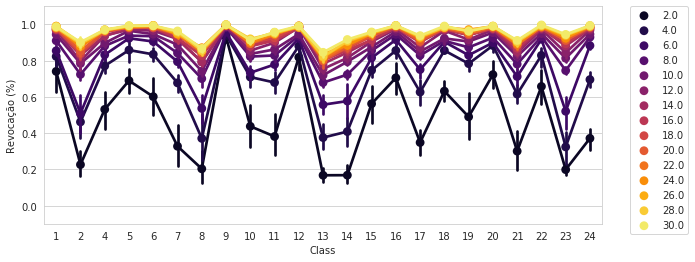

In [176]:
import matplotlib.pyplot as plt
plt.figure(figsize= (10, 4))
sns.set_style('whitegrid')
ax = sns.pointplot(data=in_res.sort_values(by=['Class', '# neurons']), 
                   palette='inferno',
                   x='Class', y = 'Revocação (%)', hue='# neurons')
ax.set_ylim(-0.1, 1.1)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# ax.set_xlim 
plt.savefig('./recall_per_class.png', dpi=200, bbox_inches='tight')

In [68]:
# sp_mean_1layer = (sp_mean_1layer.drop('SP', axis=1)
#         .melt(id_vars=['Layer1', 'Layer2', 'Layer3', 'Fold'], var_name='Class', value_name='Eficiência (%)')
#         .rename({'Layer1': '# neurons'}, axis=1))

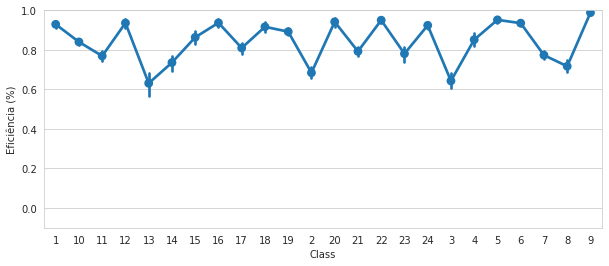

In [66]:
import matplotlib.pyplot as plt
plt.figure(figsize= (10, 4))
sns.set_style('whitegrid')
ax = sns.pointplot(data=sp_mean_1layer.loc[sp_mean_1layer['# neurons'] == 10], x='Class', y = 'Eficiência (%)')
ax.set_ylim(-0.1, 1)
plt.savefig('./modelo3.png', dpi=200)